In [1]:
# Import necessary libraries
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


from torch import nn
from data import TimeFusionDataset
from timefusion import TimeFusion
from deterministic import DeterministicForecaster
from utils.metrics import variogram_score, crps_sum
from utils.modules import EarlyStopper

In [2]:
# Import dataset
train_data = pd.read_csv("../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:30]
test_data = test_data.iloc[:,:30]

train_data.columns = list(range(train_data.shape[1]))
test_data.columns = list(range(test_data.shape[1]))

In [3]:
# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
test_data /= stds

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    #device = torch.device("mps")
    device = torch.device("cpu")
else:
    device = torch.device("cpu")

In [5]:
context_length = 96
#prediction_length = 7*24
prediction_length = 24

# Create datasets
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
)
train_dataset.add_timestamp_encodings()

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
)
val_dataset.add_timestamp_encodings()

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
)
test_dataset.add_timestamp_encodings()

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)


In [6]:
# Define deterministic model
det_predictor = DeterministicForecaster(
    prediction_length = prediction_length,
    input_size = train_dataset.tensor_data.shape[1],
    output_size = len(train_dataset.ts_columns),
    #hidden_size = 60,
    hidden_size= 40,
    fc_layers = 3,
    recurrent_layers = 2,
    scaling = True,
    device = device,
    scaler_kwargs = {"scaled_rows":list(range(30))}
)

print("Number of trainable parameters:",sum(p.numel() for p in det_predictor.parameters()))

Number of trainable parameters: 30430


In [7]:
# Train deterministic model
# optimizer = torch.optim.Adam(params=det_predictor.parameters(),lr=5e-4)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=40)

# det_predictor.train_network(
#     epochs=40,
#     train_loader = train_loader,
#     val_loader = val_loader,
#     val_metrics= {
#         "Val MAE": nn.L1Loss(),
#         #"Val MSE": nn.MSELoss()
#     },
#     #loss_function=nn.L1Loss(),
#     optimizer = optimizer,
#     lr_scheduler= lr_scheduler,
#     early_stopper=EarlyStopper(patience=10),
#     save_weights = True,
#     weight_folder = "weights/deterministic"
# )

# Loading weights
# det_predictor.load_state_dict(torch.load("weights/deterministic/2023-05-19-12-40-41"))
# det_predictor.eval()

det_predictor.load_state_dict(torch.load("weights/deterministic/2023-05-19-17-19-06"))
det_predictor.eval()

DeterministicForecaster(
  (scaler): MeanScaler()
  (rnn): LSTM(38, 40, num_layers=2, batch_first=True)
  (linear): ModuleList(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=40, bias=True)
  )
  (linear_out): Linear(in_features=40, out_features=30, bias=True)
  (relu): ReLU()
)

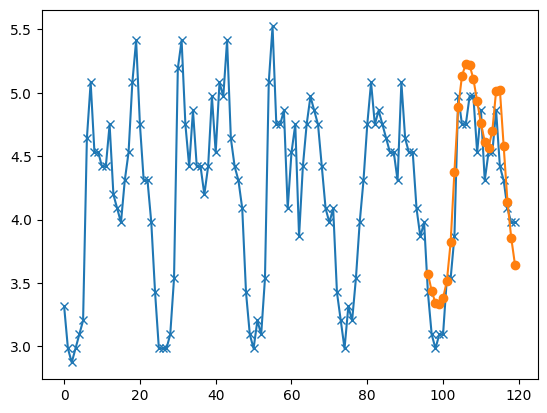

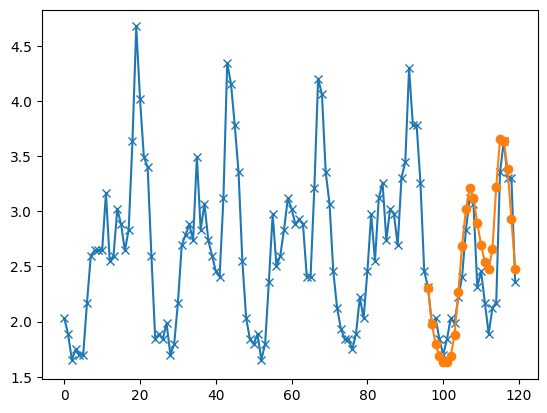

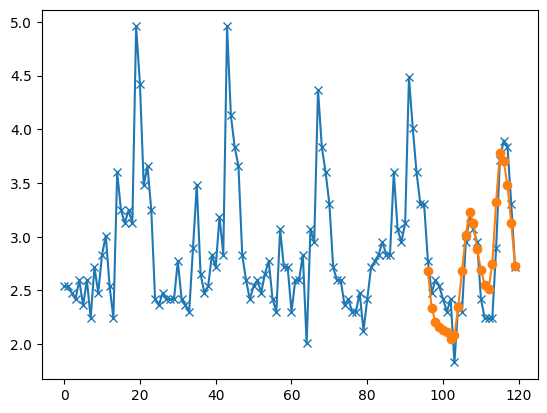

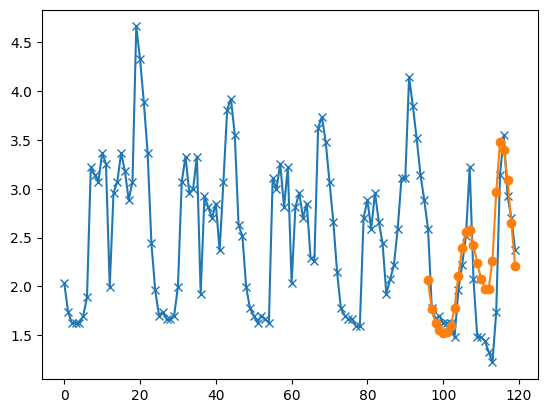

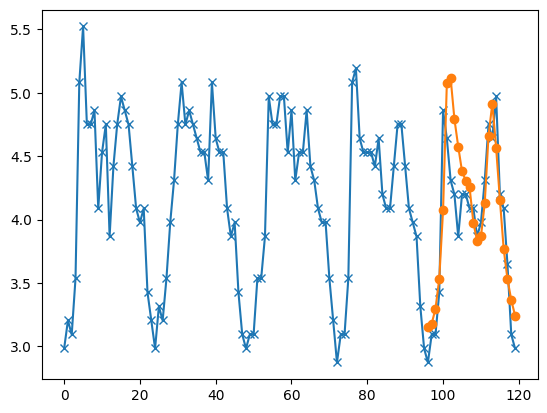

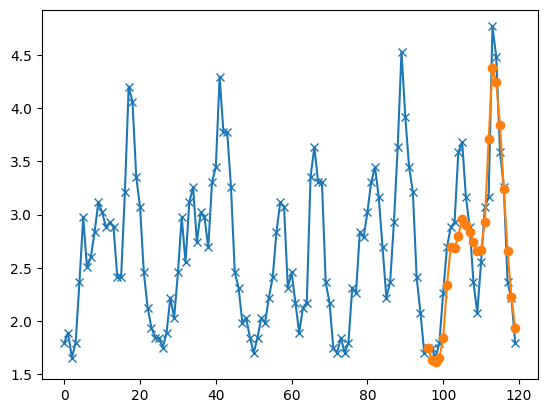

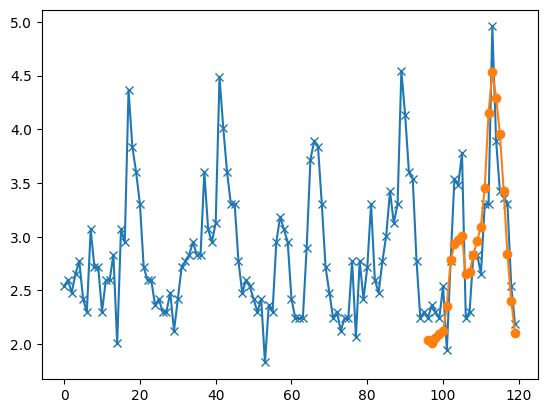

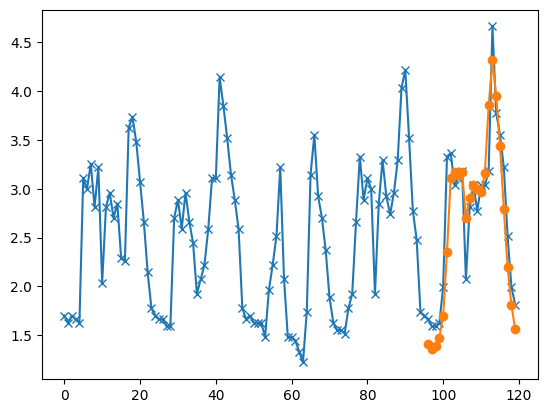

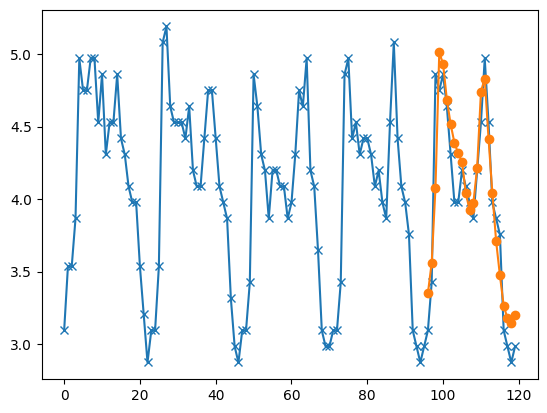

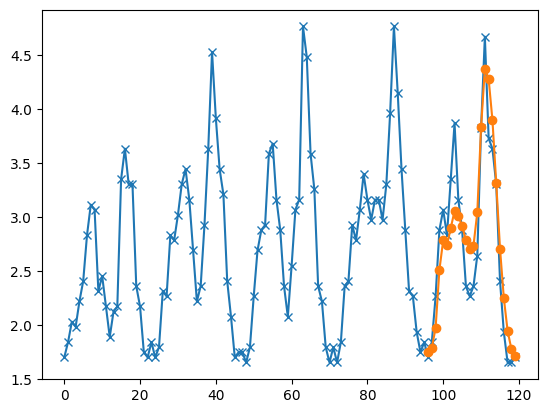

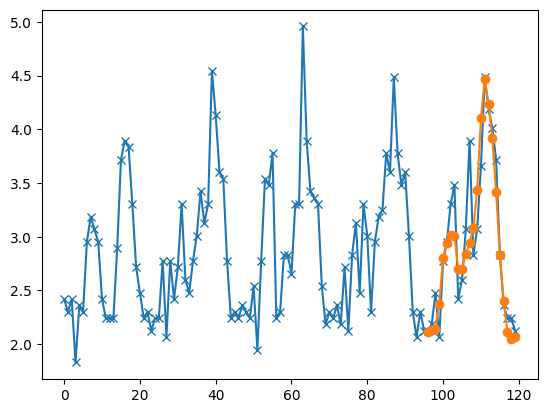

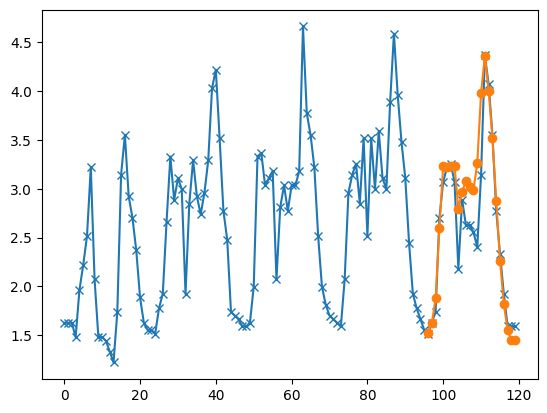

In [8]:
for idx in [0,50,100]:

    historical_data = det_predictor.sample(
        test_dataset,
        idx = [idx]
    )

    for ts in [1,5,10,15]:
        plt.figure()
        plt.plot(list(range(context_length + prediction_length)),test_dataset.tensor_data[idx:idx+context_length+prediction_length,ts],"-x")
        plt.plot(list(range(context_length,context_length+prediction_length)),historical_data[0,ts],"-o")

In [9]:
# samples = det_predictor.sample(
#     data = test_dataset,
#     idx = [0,50,100]
# )

# for i,idx in enumerate([0,50,100]):
#     for ts in [1,5,10,15]:
#         plt.figure()
#         plt.plot(list(range(context_length + prediction_length)),test_dataset.tensor_data[idx:idx+context_length+prediction_length,ts],"-x")
#         plt.plot(list(range(context_length,context_length+prediction_length)),samples[i,ts],"-x")

In [10]:
predictor = TimeFusion(
    prediction_length = prediction_length,
    input_size = train_dataset.tensor_data.shape[1],
    output_size = len(train_dataset.ts_columns),
    hidden_size = 60,
    recurrent_layers = 2,
    dropout = 0.0,
    residual_layers = 2,
    scaling = True,
    device = device,
    scaler_kwargs = {"scaled_rows":list(range(30))}
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 89094


/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/diffusion.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [11]:
# optimizer = torch.optim.Adam(params=predictor.parameters(),lr=5e-4)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=40)

# predictor.train_network(
#     train_loader = train_loader,
#     epochs=40,
#     val_loader = val_loader,
#     val_metrics= {
#         "Val MAE": nn.L1Loss(),
#     },
#     optimizer = optimizer,
#     lr_scheduler= lr_scheduler,
#     early_stopper=EarlyStopper(patience=10),
#     save_weights = True,
#     weight_folder = "weights"
# )

# Loading weights
# predictor.load_state_dict(torch.load("weights/2023-05-18-21-57-58"))
# predictor.eval()

# predictor.load_state_dict(torch.load("weights/2023-05-19-17-37-13"))
# predictor.eval()

predictor.load_state_dict(torch.load("weights/2023-05-19-19-10-27"))
predictor.eval()



TimeFusion(
  (scaler): MeanScaler()
  (diff_embedding): DiffusionEmbedding(
    (projection1): Linear(in_features=32, out_features=32, bias=True)
    (tanh1): Tanh()
    (projection2): Linear(in_features=32, out_features=32, bias=True)
  )
  (rnn): LSTM(38, 60, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=122, out_features=122, bias=True)
  (linear2): Linear(in_features=122, out_features=122, bias=True)
  (linear3): Linear(in_features=122, out_features=30, bias=True)
  (relu): ReLU()
)

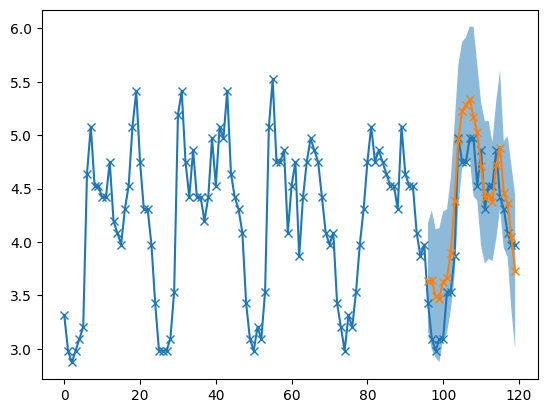

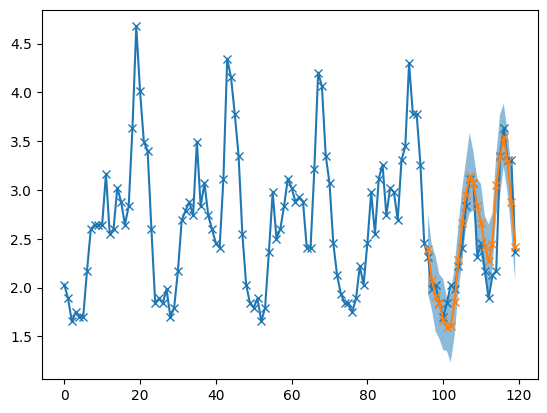

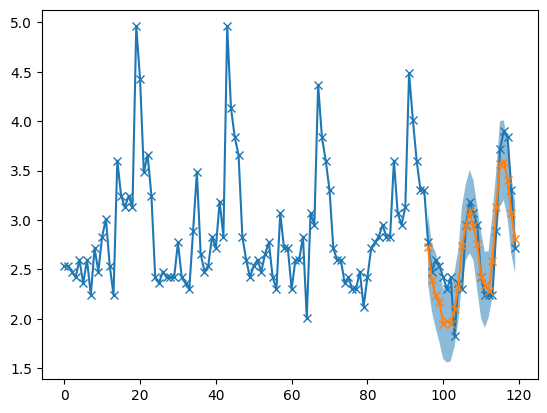

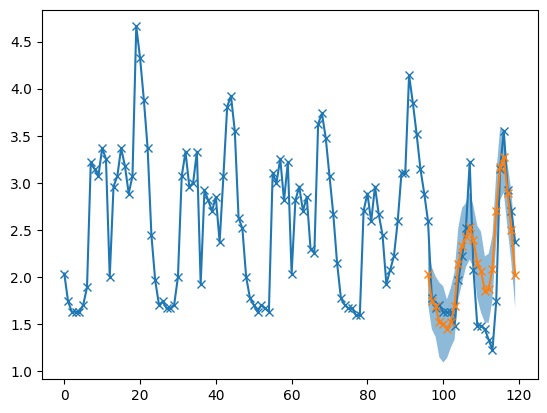

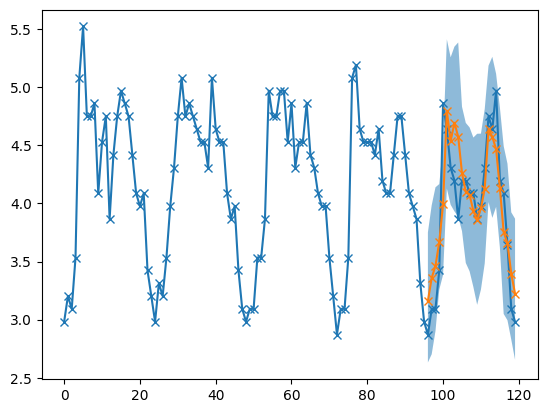

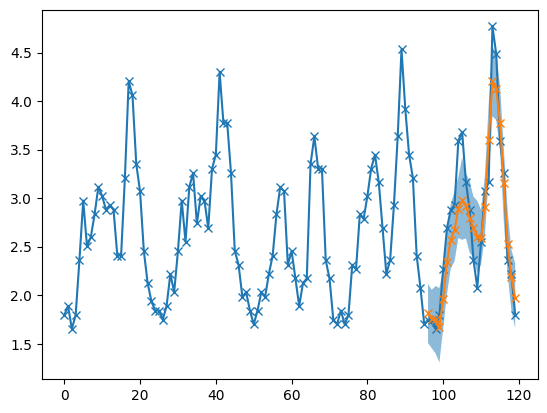

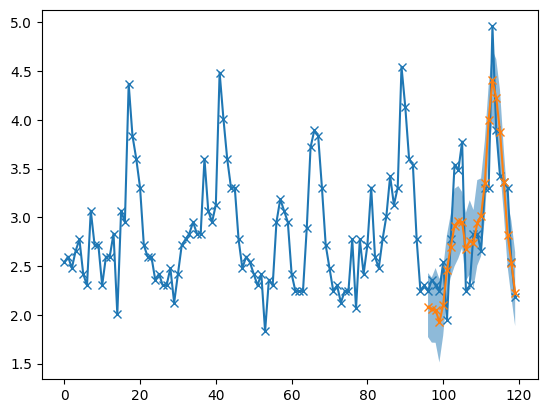

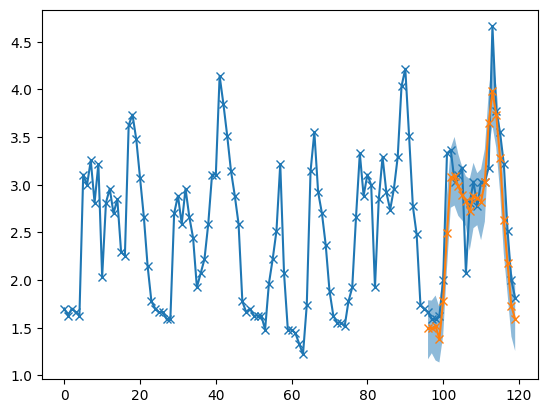

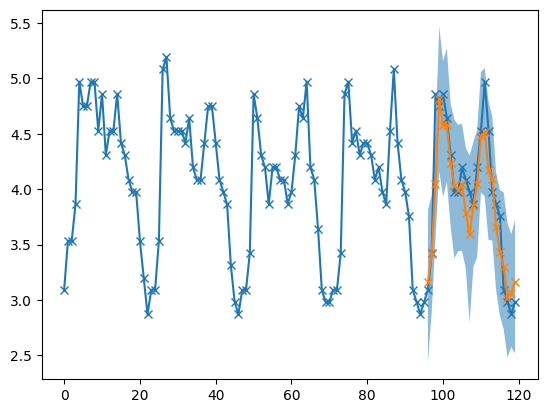

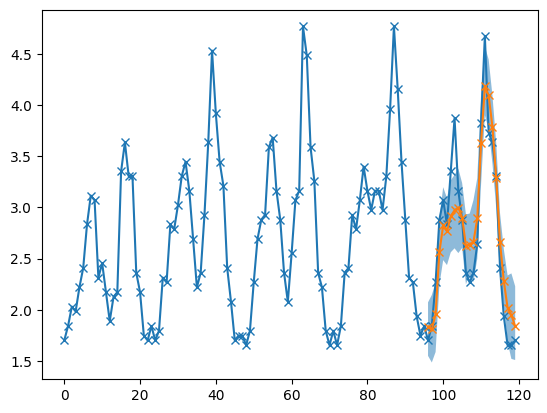

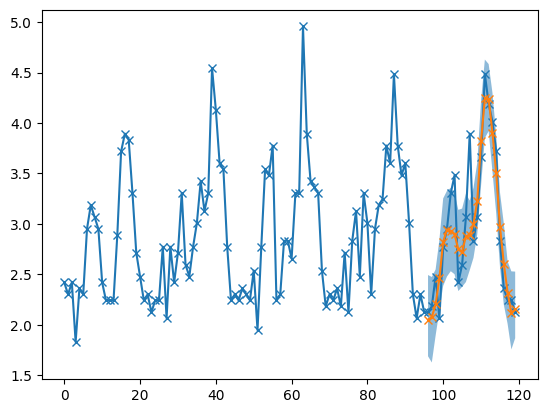

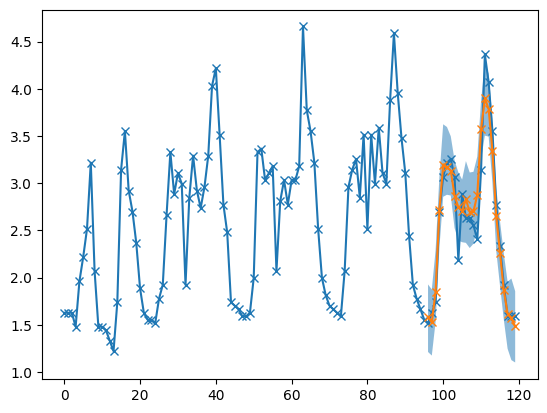

In [22]:
for idx in [0,50,100]:

    historical_data = det_predictor.sample(
        test_dataset,
        idx = [idx]
    )

    samples = predictor.sample(
        data = test_dataset,
        idx = idx,
        num_samples = 128,
        batch_size = 128,
        historical_data=historical_data.repeat(128,1,1)
    )

    confidence = 0.25
    samples_cpu = samples.cpu()
    for i in range(samples_cpu.shape[1]):
        samples_cpu[:,i,:], _ = torch.sort(samples_cpu[:,i,:], dim=0)

    for ts in [1,5,10,15]:
        plt.figure()
        plt.plot(list(range(context_length + prediction_length)),test_dataset.tensor_data[idx:idx+context_length+prediction_length,ts],"-x")
        plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples_cpu[:,ts],dim = 0),"-x")
        #plt.plot(list(range(context_length,context_length+prediction_length)),historical_data[0,ts],"-o")
        plt.fill_between(list(range(context_length,context_length+prediction_length)), samples_cpu[int(confidence*samples_cpu.shape[0]),ts], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),ts],alpha=0.5)
        plt.savefig(f"images/no_shift_{idx}_{ts}.png")

In [13]:
# Sample for first two weeks of test data
samples = []
for i in range(14):
    idx = 24*i

    historical_data = det_predictor.sample(
        test_dataset,
        idx = [idx]
    )

    samples.append(
        predictor.sample(
            data = test_dataset,
            idx = idx,
            num_samples = 128,
            batch_size = 128,
            historical_data=historical_data.repeat(128,1,1)
        ).cpu()
    )


samples = torch.stack(samples)

# samples = det_predictor.sample(
#     data = test_dataset,
#     idx = list(range(0,14*24,24))
# ).unsqueeze(1)

realisations = []
for i in range(14):
    idx = 24*i

    realisations.append(
        test_dataset.tensor_data[context_length + idx:idx + context_length + prediction_length,test_dataset.ts_columns].T
    )

realisations = torch.cat([x.unsqueeze(0) for x in realisations], dim = 0)

In [14]:
# Get numerical values for performance of network
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

# MAE and MdAE of average prediction
mse = mean_squared_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
mae = mean_absolute_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
mdae = median_absolute_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
print(f"MSE: {mse}, MAE: {mae}, MDAE: {mdae}")


# Variogram and CRPS_SUM
var_score = np.mean([variogram_score(realisations[i].numpy(), samples[i].numpy(),**{"weights":"local","window_size":3}) for i in range(realisations.shape[0])])
crps_score = np.mean([crps_sum(realisations[i].numpy(), samples[i].numpy()) for i in range(realisations.shape[0])])

print("VAR:",var_score,"CRPS_sum:",crps_score)

MSE: 0.19014771282672882, MAE: 0.31161201000213623, MDAE: 0.22236835956573486


/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/utils/metrics.py:64: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda y: (percentileofscore(F,y,kind="weak")/100 - np.heaviside(y - x, 1))**2, min(min(F),x), max(max(F),x),epsrel=1.49e-2,limit=100)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/utils/metrics.py:64: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to an

VAR: 1865.1042273867763 CRPS_sum: 1.3226349887847293


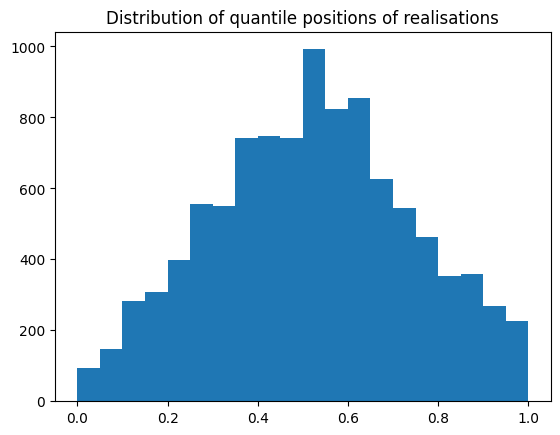

In [15]:
# Check how accurate quantiles are
quantiles = []
for i in range(samples.shape[0]):
    sorted_samples,_ = torch.clone(samples[i]).flatten(start_dim=1).sort(dim=0)
    real_copy = torch.clone(realisations[i]).flatten()

    quantiles.append([float((sorted_samples[:,i]<val).double().mean()) for i,val in enumerate(real_copy)])

plt.title("Distribution of quantile positions of realisations")
_ = plt.hist(np.array(quantiles).flatten(),20)

In [16]:
realisations.shape

torch.Size([14, 30, 24])

In [17]:
14*30

420

In [18]:
quantiles = []
for i in range(samples.shape[0]):
    sorted_samples,_ = torch.clone(samples[i]).flatten(start_dim=1).sort(dim=0)
    real_copy = torch.clone(realisations[i]).flatten()

    quantiles.append([float(torch.tensor(sorted_samples[:,i]<val,dtype=float).mean()) for i,val in enumerate(real_copy)])
    

/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_65541/849157264.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantiles.append([float(torch.tensor(sorted_samples[:,i]<val,dtype=float).mean()) for i,val in enumerate(real_copy)])


In [19]:
np.array(quantiles).flatten()

array([0.96875  , 0.4921875, 0.4921875, ..., 0.75     , 0.875    ,
       0.625    ])

(array([ 95., 148., 282., 309., 397., 556., 550., 742., 748., 741., 992.,
        824., 856., 626., 545., 462., 354., 358., 268., 227.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

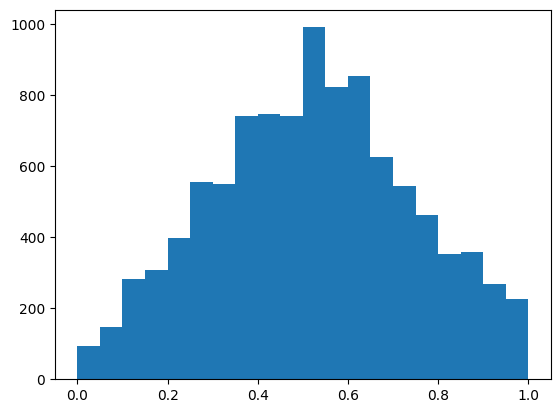

In [20]:
plt.hist(np.array(quantiles).flatten(),20)

In [21]:
sorted_samples[:,0,1]

IndexError: too many indices for tensor of dimension 2

In [ ]:
sorted_samples[sorted_samples[:,0,1]<0.5,0,1]

tensor([0.0598, 0.0626, 0.0640, 0.0742, 0.0795, 0.0923, 0.1013, 0.1129, 0.1207,
        0.1272, 0.1316, 0.1506, 0.1553, 0.1565, 0.1669, 0.1689, 0.1777, 0.1818,
        0.1864, 0.1867, 0.1901, 0.1903, 0.1945, 0.1959, 0.1985, 0.2032, 0.2048,
        0.2058, 0.2100, 0.2126, 0.2153, 0.2162, 0.2176, 0.2182, 0.2234, 0.2278,
        0.2356, 0.2371, 0.2422, 0.2464, 0.2480, 0.2510, 0.2521, 0.2532, 0.2538,
        0.2585, 0.2653, 0.2679, 0.2684, 0.2711, 0.2714, 0.2738, 0.2740, 0.2751,
        0.2803, 0.2806, 0.2810, 0.2843, 0.2847, 0.2923, 0.2972, 0.2978, 0.3016,
        0.3021, 0.3066, 0.3068, 0.3079, 0.3082, 0.3099, 0.3100, 0.3104, 0.3124,
        0.3145, 0.3166, 0.3193, 0.3198, 0.3225, 0.3266, 0.3271, 0.3294, 0.3308,
        0.3333, 0.3346, 0.3435, 0.3475, 0.3482, 0.3512, 0.3519, 0.3534, 0.3554,
        0.3583, 0.3597, 0.3598, 0.3621, 0.3622, 0.3661, 0.3666, 0.3694, 0.3793,
        0.3794, 0.3881, 0.3897, 0.3906, 0.3929, 0.3984, 0.4028, 0.4122, 0.4141,
        0.4146, 0.4225, 0.4294, 0.4352, 

In [ ]:
float(torch.tensor(sorted_samples[:,0,1]<0.5,dtype=float).mean())

/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_39603/3606895335.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(sorted_samples[:,0,1]<0.5,dtype=float).mean()


In [ ]:
[sorted_samples[:,0,1]<0.5]

[tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False, False, False, False, False, False, F

In [ ]:
float(a)

0.921875